# Brain Tumor Detection



**Introduction:**

 A brain tumor is a mass or growth of abnormal cells in our brain.

Many different types of brain tumors exist. Some brain tumors are noncancerous (benign), and some brain tumors are cancerous (malignant). Brain tumors can begin in our brain (primary brain tumors), or cancer can begin in other parts of our body and spread to our brain as secondary (metastatic) brain tumors.

How quickly a brain tumor grows can vary greatly. The growth rate as well as the location of a brain tumor determines how it will affect the function of our nervous system.

Brain tumor treatment options depend on the type of brain tumor we have, as well as its size and location.

<div style="color:Black;
           display:fill;
           border-radius:5px;
           background-color:#d4eefc;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px">
    
##Models Builded For Analyzing:

* [VGG-19 or CNN](#1)
* [Inception V3](#2)
* [VGG-16](#3)
* [Resnet-50](#4)

# 1. Importing Neccessary libraries

In [1]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

# 2. Loading Images

In [2]:
#Setting some inital parameters
height, width = 224, 224
batch_size=64

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
from google.colab import drive
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/Brain Tumor MRI/'

def image_generator(height, width, batch_size=32):  # Define batch_size
    datagen = ImageDataGenerator(
        rescale=1. / 255.,
        validation_split=0.2,
    )
    train_ds = datagen.flow_from_directory(
        data_dir,
        batch_size=batch_size,
        subset="training",
        # color_mode = 'grayscale',
        shuffle=True,
        class_mode='binary',
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )
    val_ds = datagen.flow_from_directory(
        data_dir,
        subset="validation",
        # seed=123,
        # color_mode = 'grayscale',
        class_mode='binary',
        target_size=(height, width),
        batch_size=batch_size,
        classes={'no': 0., 'yes': 1.}
    )
    return train_ds, val_ds

height = 150  # Specify height
width = 150  # Specify width
batch_size = 32  # Specify batch size
train_ds, val_ds = image_generator(height, width, batch_size)

total_image = np.concatenate([train_ds.labels, val_ds.labels])
print('\n\n', {'No_brain_tumor_cases': len(np.where(total_image == 0)[0]),
               'brain_tumor_cases': len(np.where(total_image == 1)[0])})


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No_brain_tumor_cases': 98, 'brain_tumor_cases': 155}


## 3. Image demo

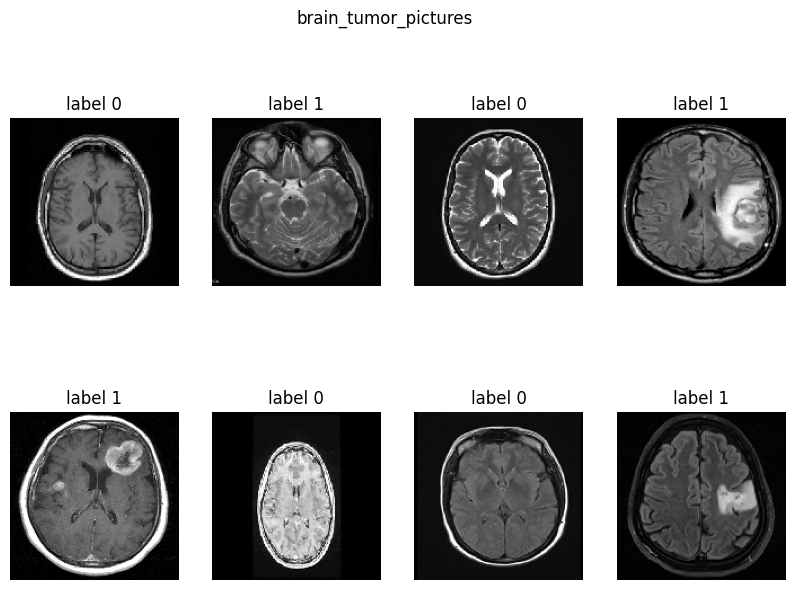

In [5]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures")
for k in range(8):
    images, labels = train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

# 4. Models Implementation

## 4.1 VGG-19 (CNN) Implementation



In [6]:
#Model Creation VGG-19(CNN)
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
model_vgg19.add(tf.keras.layers.Flatten())

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.summary()

80134624/80134624 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8193      
                                                                 
Total params: 20032577 (76.42 MB)
Trainable params: 8193 (32.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [7]:
#Training VGG-19(CNN)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_vgg19.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 2.1137 - acc: 0.5419
Epoch 1: acc improved from -inf to 0.54187, saving model to model/vgg19_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 101s 14s/step - loss: 2.1137 - acc: 0.5419 - val_loss: 0.8676 - val_acc: 0.7400
Epoch 2/25
7/7 [==============================] - ETA: 0s - loss: 0.7809 - acc: 0.7291
Epoch 2: acc improved from 0.54187 to 0.72906, saving model to model/vgg19_best.h5
7/7 [==============================] - 92s 13s/step - loss: 0.7809 - acc: 0.7291 - val_loss: 0.8826 - val_acc: 0.7000
Epoch 3/25
7/7 [==============================] - ETA: 0s - loss: 0.8210 - acc: 0.7586
Epoch 3: acc improved from 0.72906 to 0.75862, saving model to model/vgg19_best.h5
7/7 [==============================] - 112s 17s/step - loss: 0.8210 - acc: 0.7586 - val_loss: 0.7241 - val_acc: 0.8200
Epoch 4/25
7/7 [==============================] - ETA: 0s - loss: 0.6995 - acc: 0.8128
Epoch 4: acc improved from 0.75862 to 0.81281, saving model to model/vgg19_best.h5
7/7 [==============================] - 92s 13s/step - loss: 0.6995 - acc: 0.8128 - val_loss: 0.3052 - val_acc: 0.8200
Epoch 5/25
7/7 [

In [ ]:
#Training and Validation Results VGG-19(CNN)
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 15s 5s/step - loss: 0.2258 - acc: 0.9200


,Train,Val
Loss,0.032861,0.225805
Acc,1.000000,0.920000


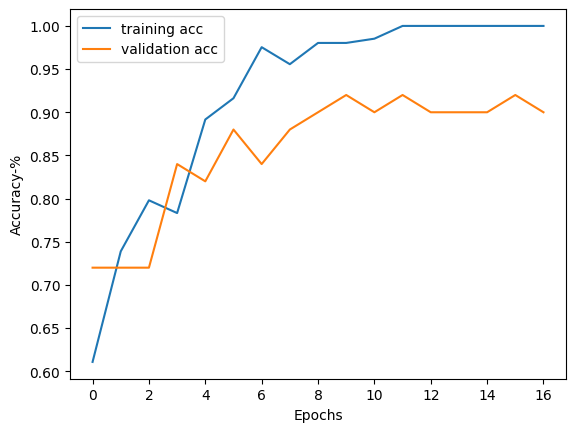

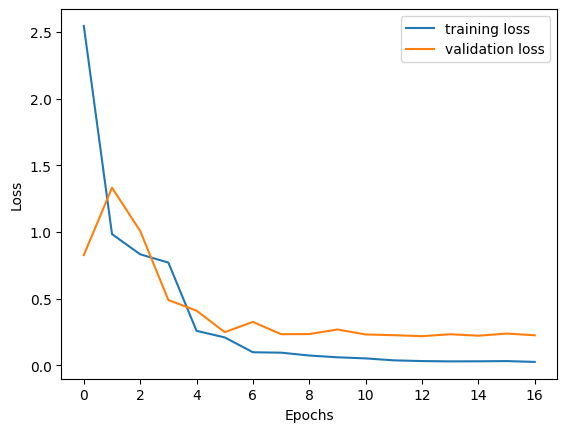

In [ ]:
# Ploting Learning Curve VGG-19
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

<h3>Adding Image Augmentation</h3>

In [ ]:
def augmentataion_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=64,
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    return aug_train_ds
aug_train_ds = augmentataion_generator(height,width)

Found 253 images belonging to 2 classes.


In [ ]:
#Image Augementation Training VGG-19(CNN)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,reduce_lr]

history = model_vgg19.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 0.4542 - acc: 0.7866 
Epoch 1: acc did not improve from 1.00000
4/4 [==============================] - 100s 26s/step - loss: 0.4542 - acc: 0.7866 - val_loss: 0.2322 - val_acc: 0.9000 - lr: 0.0100
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.3421 - acc: 0.8538 
Epoch 2: acc did not improve from 1.00000
4/4 [==============================] - 96s 25s/step - loss: 0.3421 - acc: 0.8538 - val_loss: 0.3952 - val_acc: 0.8800 - lr: 0.0100
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.2702 - acc: 0.8735 
Epoch 3: acc did not improve from 1.00000
4/4 [==============================] - 95s 25s/step - loss: 0.2702 - acc: 0.8735 - val_loss: 0.3581 - val_acc: 0.8800 - lr: 0.0100
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.3335 - acc: 0.8458 
Epoch 4: acc did not improve from 1.00000
4/4 [==============================] - 98s 25s/step - loss: 0.3335 - acc: 0.8458 - val

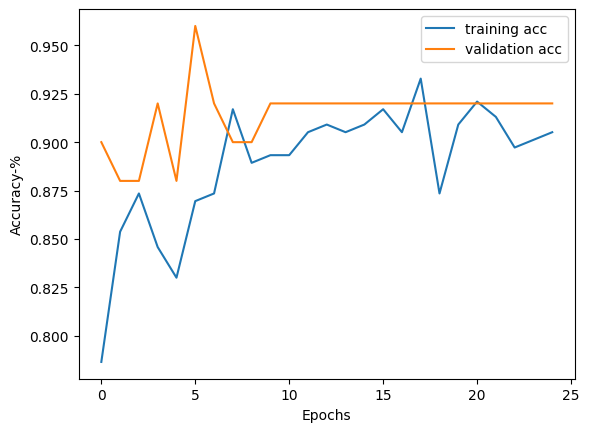

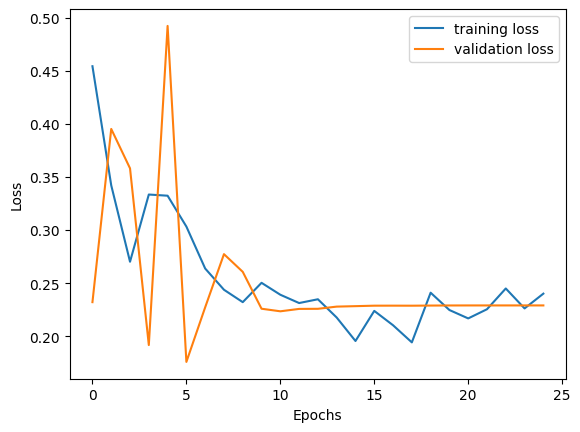

In [ ]:
#Updated Learning Curve VGG-19(CNN)
plot_learning_curve(history)

##VGG-19(CNN) model results

In [ ]:
#Updated Training And Validation Results VGG-19(CNN)
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 15s 5s/step - loss: 0.2291 - acc: 0.9200


,Train,Val
Loss,0.075038,0.229136
Acc,0.980296,0.920000


In [ ]:
#Performance Metrics for VGG-19(CNN)
ypred_val = model_vgg19.predict(val_ds[0][0])
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])
y_val = val_ds[0][-1]

print(confusion_matrix(y_val, ypred_val))
print('\n',classification_report(ypred_val,y_val))

1/1 [==============================] - 9s 9s/step
[[13  0]
 [ 2 17]]

               precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.89      1.00      0.94        17

    accuracy                           0.94        32
   macro avg       0.95      0.93      0.94        32
weighted avg       0.94      0.94      0.94        32



## 4.2 Inception V3 Implementation


In [ ]:
#Model Creation Inception V3
height = 299
width = 299

train_ds, val_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_inceptionv3.summary()

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21933857 (83.67 MB)
Trainable params: 131073 (512.00 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
#Training Inception V3
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 3.5584 - acc: 0.6552
Epoch 1: acc improved from -inf to 0.65517, saving model to model/inceptionv3_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 65s 9s/step - loss: 3.5584 - acc: 0.6552 - val_loss: 2.1661 - val_acc: 0.7000
Epoch 2/25
7/7 [==============================] - ETA: 0s - loss: 0.8037 - acc: 0.8522
Epoch 2: acc improved from 0.65517 to 0.85222, saving model to model/inceptionv3_best.h5
7/7 [==============================] - 56s 8s/step - loss: 0.8037 - acc: 0.8522 - val_loss: 1.0105 - val_acc: 0.9000
Epoch 3/25
7/7 [==============================] - ETA: 0s - loss: 0.1040 - acc: 0.9655
Epoch 3: acc improved from 0.85222 to 0.96552, saving model to model/inceptionv3_best.h5
7/7 [==============================] - 65s 10s/step - loss: 0.1040 - acc: 0.9655 - val_loss: 0.7874 - val_acc: 0.9600
Epoch 4/25
7/7 [==============================] - ETA: 0s - loss: 0.0519 - acc: 0.9803
Epoch 4: acc improved from 0.96552 to 0.98030, saving model to model/inceptionv3_best.h5
7/7 [==============================] - 66s 10s/step - loss: 0.0519 - acc: 0.9803 - val_loss: 0.7898 - val_acc: 0.9400
Ep

In [ ]:
#Training and Validation Results Inception V3
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 11s 4s/step - loss: 0.7798 - acc: 0.9200


,Train,Val
Loss,0.000502,0.779768
Acc,1.000000,0.920000


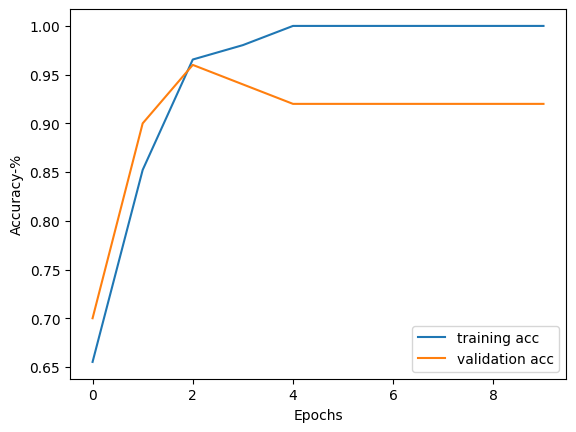

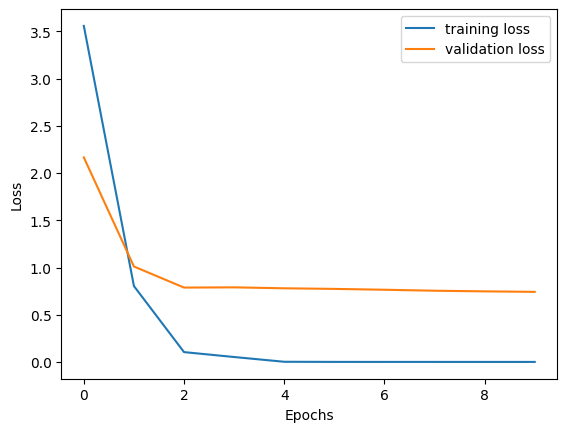

In [ ]:
# Ploting Learning Curve Inception V3
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

<h3>Adding Image augmentation</h3>

In [ ]:
def augmentataion_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=64,
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    return aug_train_ds
aug_train_ds = augmentataion_generator(height,width)

Found 253 images belonging to 2 classes.


In [ ]:
#Image Augementation Training Inception V3
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3, patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint, reduce_lr]

history = model_inceptionv3.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=25,
    verbose=True,
    callbacks=callbacks_list)


Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 1.3071 - acc: 0.8063 
Epoch 1: acc did not improve from 1.00000
4/4 [==============================] - 96s 23s/step - loss: 1.3071 - acc: 0.8063 - val_loss: 2.2613 - val_acc: 0.7200 - lr: 0.0010
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.8912 - acc: 0.8617 
Epoch 2: acc did not improve from 1.00000
4/4 [==============================] - 94s 25s/step - loss: 0.8912 - acc: 0.8617 - val_loss: 0.5294 - val_acc: 0.9600 - lr: 0.0010
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 1.1532 - acc: 0.8696 
Epoch 3: acc did not improve from 1.00000
4/4 [==============================] - 85s 22s/step - loss: 1.1532 - acc: 0.8696 - val_loss: 1.2481 - val_acc: 0.7800 - lr: 0.0010
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.8845 - acc: 0.8735 
Epoch 4: acc did not improve from 1.00000
4/4 [==============================] - 87s 21s/step - loss: 0.8845 - acc: 0.8735 - val_

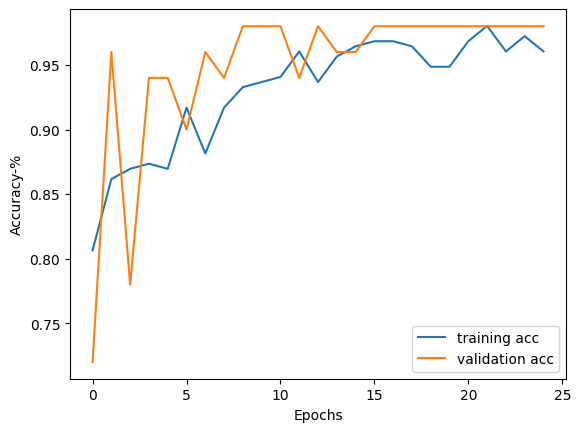

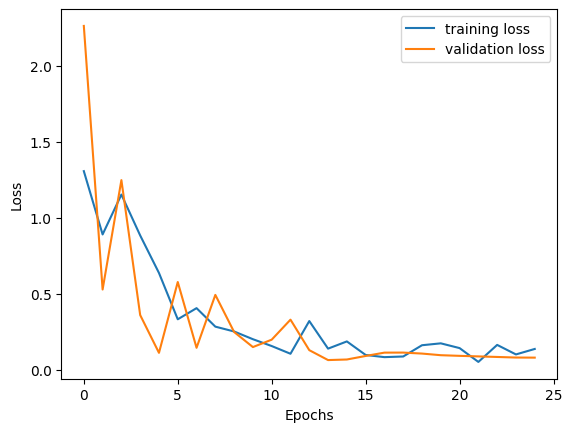

In [ ]:
#Updated Learning Curve Inception V3
plot_learning_curve(history)

##InceptionV3 model results

In [ ]:
#Updated Training And Validation Results Inception V3
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 11s 3s/step - loss: 0.0818 - acc: 0.9800


,Train,Val
Loss,0.002323,0.081786
Acc,1.000000,0.980000


In [ ]:
#Performance Metrics for Inception V3
ypred = model_inceptionv3.predict(val_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = val_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

1/1 [==============================] - 9s 9s/step
Confusion_Matrix:
 [[13  1]
 [ 0 18]]

Classification_report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.95      0.97        19

    accuracy                           0.97        32
   macro avg       0.96      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



## 4.3 VGG-16 Implementation

In [ ]:
#Model Creation VGG-16
height = 299  # Specify height
width = 299  # Specify width

train_ds, val_ds = image_generator(height, width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)

base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg16.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['acc']
)

model_vgg16.summary()


Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 1)                 41473     
                                                                 
Total params: 14756161 (56.29 MB)
Trainable params: 41473 (162.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
#Training VGG-16
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint, early]

history = model_vgg16.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    verbose=True,
    callbacks=callbacks_list)


Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 1.1387 - acc: 0.6355 
Epoch 1: acc improved from -inf to 0.63547, saving model to model/vgg16_best.h5
7/7 [==============================] - 274s 44s/step - loss: 1.1387 - acc: 0.6355 - val_loss: 0.5276 - val_acc: 0.7600
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.6609 - acc: 0.7143 
Epoch 2: acc improved from 0.63547 to 0.71429, saving model to model/vgg16_best.h5
7/7 [==============================] - 265s 39s/step - loss: 0.6609 - acc: 0.7143 - val_loss: 0.9472 - val_acc: 0.7400
Epoch 3/25
7/7 [==============================] - ETA: 0s - loss: 0.4231 - acc: 0.8424 
Epoch 3: acc improved from 0.71429 to 0.84236, saving model to model/vgg16_best.h5
7/7 [==============================] - 264s 39s/step - loss: 0.4231 - acc: 0.8424 - val_loss: 0.6124 - val_acc: 0.7600
Epoch 4/25
7/7 [==============================] - ETA: 0s - loss: 0.2967 - acc: 0.9015 
Epoch 4: acc improved from 0.84236 to 0.90148, saving model to model/vgg16_best.h5
7/7 [==============================] - 263s 42s/step - loss: 0.2967 - acc: 0.9015 - val_loss: 0.6678 - val_acc: 0.8000
Epoch 5/25
7/7 [==============================] - ETA: 0s - loss: 0.2180 - acc: 0.8916 
Epoch 5: acc did not improve from 0.90148
7/7 [======

In [ ]:
#Training and Validation Results VGG-16
train_result = model_vgg16.evaluate(train_ds)
val_result = model_vgg16.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result, val_result), columns=['Train', 'Val'], index=['Loss', 'Acc'])
no_augmented_df


2/2 [==============================] - 46s 16s/step - loss: 0.3092 - acc: 0.8400


,Train,Val
Loss,0.035564,0.309204
Acc,1.000000,0.840000


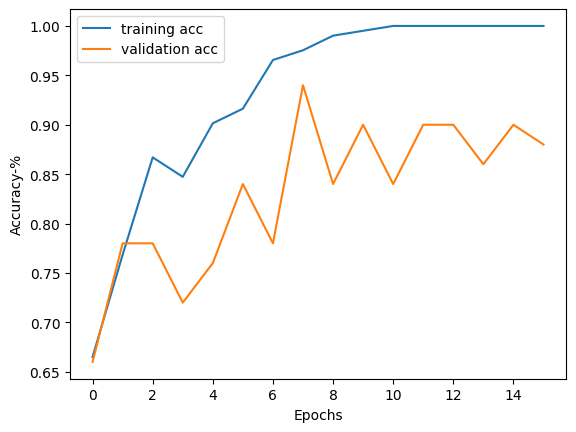

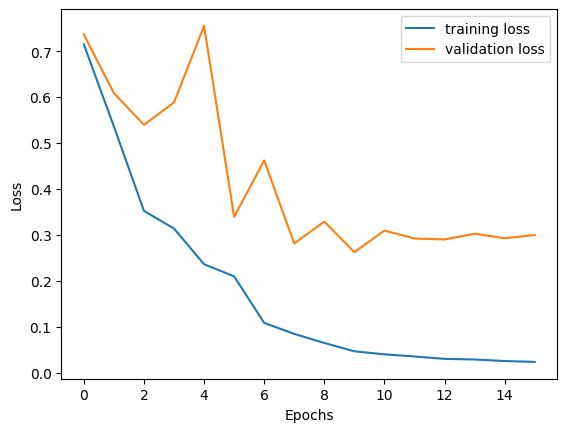

In [ ]:
#Ploting Learning Curve VGG-16
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)


<h3>Adding Image augmentation</h3>

In [ ]:
def augmentation_generator(height, width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=64,
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    return aug_train_ds

aug_train_ds = augmentation_generator(height, width)


Found 253 images belonging to 2 classes.


In [ ]:
#Image Augementation Training VGG-16
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3, patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint, reduce_lr]

history = model_vgg16.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=25,
    verbose=True,
    callbacks=callbacks_list)


Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 0.3493 - acc: 0.8498  
Epoch 1: acc did not improve from 1.00000
4/4 [==============================] - 300s 78s/step - loss: 0.3493 - acc: 0.8498 - val_loss: 0.3283 - val_acc: 0.8400 - lr: 0.0010
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.3620 - acc: 0.8300  
Epoch 2: acc did not improve from 1.00000
4/4 [==============================] - 328s 88s/step - loss: 0.3620 - acc: 0.8300 - val_loss: 0.2756 - val_acc: 0.9200 - lr: 0.0010
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.3523 - acc: 0.8498  
Epoch 3: acc did not improve from 1.00000
4/4 [==============================] - 331s 88s/step - loss: 0.3523 - acc: 0.8498 - val_loss: 0.2798 - val_acc: 0.8600 - lr: 0.0010
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.3415 - acc: 0.8261  
Epoch 4: acc did not improve from 1.00000
4/4 [==============================] - 306s 80s/step - loss: 0.3415 - acc: 0.826

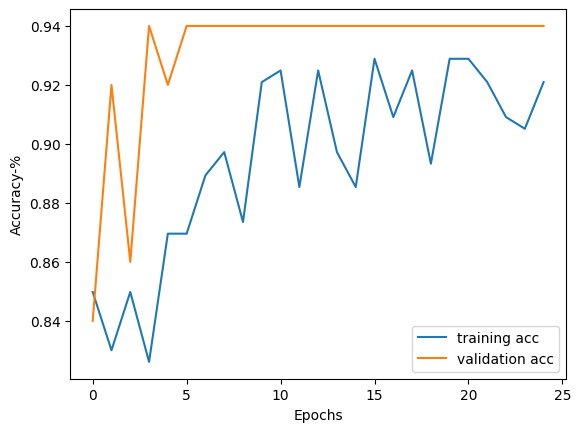

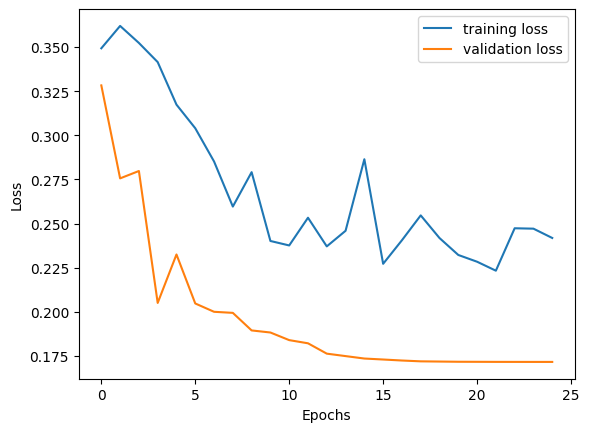

In [ ]:
#Updated Learning Curve VGG-16
plot_learning_curve(history)

##VGG16 model results

In [ ]:
#Updated Training And Validation Results VGG-16
train_result_vgg16 = model_vgg16.evaluate(train_ds)
val_result_vgg16 = model_vgg16.evaluate(val_ds)

vgg16_df = pd.DataFrame(zip(train_result_vgg16, val_result_vgg16), columns=['Train', 'Val'], index=['Loss', 'Acc'])
vgg16_df


2/2 [==============================] - 49s 16s/step - loss: 0.1717 - acc: 0.9400


,Train,Val
Loss,0.033679,0.171652
Acc,0.995074,0.940000


In [ ]:
#Performance Metrics for VGG-16
ypred_vgg16 = model_vgg16.predict(val_ds[0][0])
ypred_vgg16 = np.array([1 if x > 0.5 else 0 for x in ypred_vgg16])
ytest_vgg16 = val_ds[0][-1]

print('Confusion Matrix (VGG-16):\n', confusion_matrix(ytest_vgg16, ypred_vgg16))
print('\nClassification Report (VGG-16):\n', classification_report(ytest_vgg16, ypred_vgg16))


1/1 [==============================] - 31s 31s/step
Confusion Matrix (VGG-16):
 [[14  2]
 [ 0 16]]

Classification Report (VGG-16):
               precision    recall  f1-score   support

         0.0       1.00      0.88      0.93        16
         1.0       0.89      1.00      0.94        16

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



## 4.4 Resnet-50 Implementation

In [8]:
#Model Creation Resnet-50
height = 299  # Specify height
width = 299  # Specify width

train_ds, val_ds = image_generator(height, width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)

base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_resnet50 = tf.keras.Sequential()
model_resnet50.add(base_model)
model_resnet50.add(tf.keras.layers.Flatten())
model_resnet50.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_resnet50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['acc']
)

model_resnet50.summary()


Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 1)                 204801    
                                                                 
Total params: 23792513 (90.76 MB)
Trainable params: 204801 (800.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [9]:
#Training Resnet-50
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50_best.h5', monitor='acc', verbose=1, mode='max', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint, early]

history = model_resnet50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    verbose=True,
    callbacks=callbacks_list)


Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 4.2564 - acc: 0.5862 
Epoch 1: acc improved from -inf to 0.58621, saving model to model/resnet50_best.h5
7/7 [==============================] - 130s 18s/step - loss: 4.2564 - acc: 0.5862 - val_loss: 3.5196 - val_acc: 0.6400
Epoch 2/25
7/7 [==============================] - ETA: 0s - loss: 2.6101 - acc: 0.6404 
Epoch 2: acc improved from 0.58621 to 0.64039, saving model to model/resnet50_best.h5
7/7 [==============================] - 123s 19s/step - loss: 2.6101 - acc: 0.6404 - val_loss: 3.4007 - val_acc: 0.7000
Epoch 3/25
7/7 [==============================] - ETA: 0s - loss: 1.7411 - acc: 0.7291 
Epoch 3: acc improved from 0.64039 to 0.72906, saving model to model/resnet50_best.h5
7/7 [==============================] - 99s 14s/step - loss: 1.7411 - acc: 0.7291 - val_loss: 2.2354 - val_acc: 0.6800
Epoch 4/25
7/7 [==============================] - ETA: 0s - loss: 0.9917 - acc: 0.8177 
Epoch 4: acc improved from 0.72906 to

In [10]:
#Training and Validation Results Resnet-50
train_result = model_resnet50.evaluate(train_ds)
val_result = model_resnet50.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result, val_result), columns=['Train', 'Val'], index=['Loss', 'Acc'])
no_augmented_df


2/2 [==============================] - 21s 8s/step - loss: 0.8860 - acc: 0.7400


,Train,Val
Loss,0.127521,0.885977
Acc,0.940887,0.740000


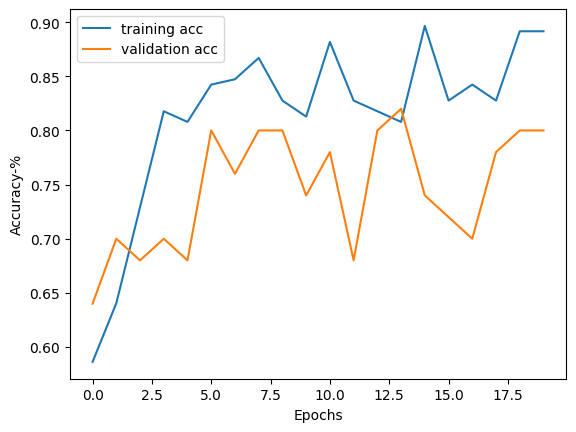

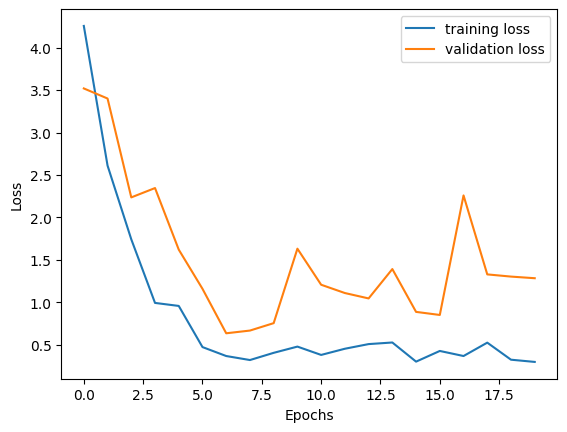

In [11]:
# Ploting Learning Curve Resnet-50
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)


<h3>Adding Image augmentation</h3>

In [ ]:
def augmentation_generator(height, width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=64,
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    return aug_train_ds

aug_train_ds = augmentation_generator(height, width)


Found 253 images belonging to 2 classes.


In [ ]:
#Image Augementation Training Resnet-50
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.3, patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint, reduce_lr]

history = model_resnet50.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=25,
    verbose=True,
    callbacks=callbacks_list)


Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 1.9134 - acc: 0.6403 
Epoch 1: acc did not improve from 0.93103
4/4 [==============================] - 126s 29s/step - loss: 1.9134 - acc: 0.6403 - val_loss: 2.0342 - val_acc: 0.5600 - lr: 0.0010
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 3.6941 - acc: 0.4704 
Epoch 2: acc did not improve from 0.93103
4/4 [==============================] - 118s 30s/step - loss: 3.6941 - acc: 0.4704 - val_loss: 2.7045 - val_acc: 0.6600 - lr: 0.0010
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 1.8169 - acc: 0.6087 
Epoch 3: acc did not improve from 0.93103
4/4 [==============================] - 114s 29s/step - loss: 1.8169 - acc: 0.6087 - val_loss: 2.4274 - val_acc: 0.6600 - lr: 0.0010
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 2.2999 - acc: 0.6087 
Epoch 4: acc did not improve from 0.93103
4/4 [==============================] - 117s 30s/step - loss: 2.2999 - acc: 0.6087 - 

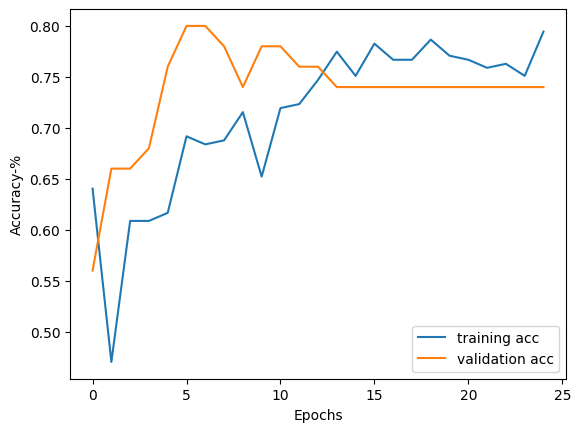

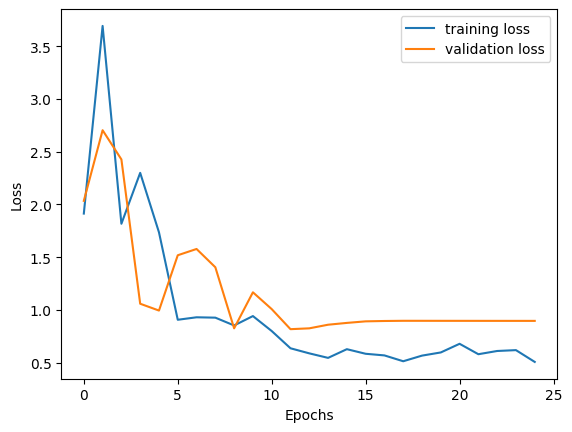

In [ ]:
#Updated Learning Curve Resnet-50
plot_learning_curve(history)

##Resnet-50 model results

In [ ]:
#Updated Training And Validation Results Resnet-50
train_result_resnet50 = model_resnet50.evaluate(train_ds)
val_result_resnet50 = model_resnet50.evaluate(val_ds)

resnet50_df = pd.DataFrame(zip(train_result_resnet50, val_result_resnet50), columns=['Train', 'Val'], index=['Loss', 'Acc'])
resnet50_df


2/2 [==============================] - 18s 7s/step - loss: 0.8953 - acc: 0.7400


,Train,Val
Loss,0.163113,0.895297
Acc,0.931035,0.740000


In [ ]:
#Performance Metrics for Resnet-50
ypred_resnet50 = model_resnet50.predict(val_ds[0][0])
ypred_resnet50 = np.array([1 if x > 0.5 else 0 for x in ypred_resnet50])
ytest_resnet50 = val_ds[0][-1]

print('Confusion Matrix (ResNet-50):\n', confusion_matrix(ytest_resnet50, ypred_resnet50))
print('\nClassification Report (ResNet-50):\n', classification_report(ytest_resnet50, ypred_resnet50))


1/1 [==============================] - 69s 69s/step
Confusion Matrix (ResNet-50):
 [[ 7  8]
 [ 2 15]]

Classification Report (ResNet-50):
               precision    recall  f1-score   support

         0.0       0.78      0.47      0.58        15
         1.0       0.65      0.88      0.75        17

    accuracy                           0.69        32
   macro avg       0.71      0.67      0.67        32
weighted avg       0.71      0.69      0.67        32



## 5  Conclusion and Novelty
Thus,After adding image augmentations and by using adam optimizer, the model accuracy improved a lot and values of performance metrics also increased than before.When it is not used the accuracy is low and performance metrics values is also low
